<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Test/Variational_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Variational Inference on the Test Data

## Importing Packages

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax

## Load Test Data

In [5]:
testx = jnp.load('drive/MyDrive/Project/Test/Testx.npy').astype('f')
testy = jnp.load('drive/MyDrive/Project/Test/Testy.npy')
inw = jnp.load('drive/MyDrive/Project/Test/Inputwin.npy')
outw = jnp.load('drive/MyDrive/Project/Test/Outputwin.npy')

In [6]:
k = np.shape(testx)[0]-1
m = np.shape(testy)[0] - k - 1
binw = inw/k
timex = np.linspace(0.0, k*binw, k+1)
timey = np.linspace(0.0, (m+k)*binw, k+m+1)

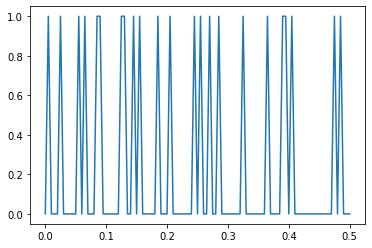

In [7]:
plt.plot(timex, testx)

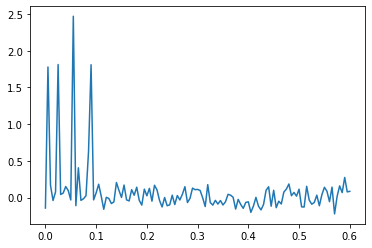

In [8]:
plt.plot(timey, testy)

## Function Definitions

### Testing Functions

In [9]:
@jit
def squared_exp2(I, J, Ell, Sigma_f):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2*Ell**2.0))

In [10]:
vec_SE = jit(vmap(vmap(squared_exp2, in_axes=[0,None,None,None]),in_axes=[None,0,None,None]))

### Variational Bound (ELBO)

#### KL Divergence

In [33]:
@jit
def kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu):
  Num_inducing = jnp.shape(L_matrix)[0]
  return jnp.sum(jnp.log(jnp.diag(L_matrix))) + 0.5*(jnp.linalg.norm(L_matrix)**2) + \
            0.5*(jnp.linalg.norm(jnp.linalg.lstsq(Prior_cov_root, Mu_prior)[0] - Param_vu)**2) - \
            Num_inducing/2

#### Cholesky Check

In [12]:
@jit
def checknans(Symmetric_Matrix, Power):
  # Power MUST be input as a float
  M = jnp.shape(Symmetric_Matrix)[0]
  return Symmetric_Matrix, jnp.isnan(jnp.linalg.cholesky(Symmetric_Matrix + (10**Power)*jnp.eye(M))).any().astype('f')

In [13]:
@jit
def choleskypwr(Symmetric_Matrix):
  Number_check = 15
  Power_list = -1*jnp.arange(Number_check + 1, dtype='f')
  _, Failure = lax.scan(checknans, Symmetric_Matrix, Power_list)
  return Failure

In [14]:
def choleskyit(Symmetric_Matrix):
  Number_check = 10
  Power_list = -1*jnp.arange(Number_check+1)
  Base_list = 10*jnp.ones(Number_check)
  Lambdas = jnp.power(Base_list, Power_list)
  M = jnp.shape(Symmetric_Matrix)[0]
  Larr = jnp.linalg.cholesky(Symmetric_Matrix).flatten()
  Ind = 1

  while jnp.isnan(Larr).any():
    Larr = jnp.linalg.cholesky(Symmetric_Matrix + Lambdas.at[-Ind].get()*jnp.eye(M)).flatten()
    Ind += 1

  return Larr.reshape((M, M))

#### Sampling from $q(f)$

In [ ]:
@jit
def covqf()

#### Data to test the functions individually

In [18]:
# Generate random key
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 3)
subkeyl = subkeys[0]
subkeysig = subkeys[1]

# Generated test inducing points
num_ind = 10
tstloc = random.truncated_normal(key, 0.0, timey[-1]-timex[-1], (num_ind,))
tstloc = jnp.sort(tstloc)

# Generate covariance of inducing points with SE function (for ease, shouldn't ...
# do this for actual thing)
l_param = random.uniform(subkeyl)
sigma_param = random.uniform(subkeysig)
Gmat = vec_SE(tstloc, tstloc, l_param, sigma_param)

chol_chek = choleskypwr(Gmat)

Lnew = jnp.linalg.cholesky(Gmat + chol_chek.any()*(10**(-10+jnp.sum(chol_chek)))*jnp.eye(num_ind))

# Generate arbitrary lower triangular matrix (not from PSD or symmetric)
tstmat = jnp.zeros((4,4))
tstmat = tstmat.at[jnp.tril_indices(4)].set(jnp.arange(1,11).astype('f'))